# Clasificador de Propinas para Viajes en Taxi en NYC (2020)

Inspirado en la charla ["Keeping up with Machine Learning in Production"](https://github.com/shreyashankar/debugging-ml-talk) de [Shreya Shankar](https://twitter.com/sh_reya)


Este notebook muestra la construcción de un modelo de machine learning de juguete, usando datos de viajes de los taxis amarillos de Nueva York para el año 2020, [proporcionados por la NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). 

La idea es encontrar aquellos viajes donde la propina dejada por el pasajero fue alta, es decir, mayor al 20% del costo del viaje.

Para ello ajustaremos un modelo de classificación binaria RandomForest usando los datos de los viajes de enero de 2020. Probaremos el modelo resultante sobre los datos de los viajes de febrero de 2020. Compararemos el desempeño del modelo en ambos casos usando la métrica de [f1-score](https://en.wikipedia.org/wiki/F-score).

Adicionalmente se intentara responder a la pregunta "Covid-19 fue factor en que los datos cambiaran?", analizando la metria f-1, variaciones de la distribucion de variables (valga la redundancia) a travez del tiempo o si derechamente existe un cambio de realidad.

Esto se realiza en base al documento "00_nyc-taxi-model.ipynb" el cual fue clonado y renombrado a "00_nyc-taxi-model.ipynb" y ademas se trabaja en una rama off line local haciendo pull y push a los cambios que se realicen al documento (en algunos caso tambien en google colab)

El repo se encuentra en https://github.com/MorgaFD/tarea_1_dp el cual esta en modo publico para que pueda ser revisado


## Cargando las librerías necesarias

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Mantendremos el mes de enero como entrenamieto, ya que es nuestro punto de inicio y un buen punto para el analisis de los meses venideros, ademas que el modelo no es lo que se quiere analizar ni tampoco responde a nuestra pregunta de alto nivel.
Porn ende, la construccion del modelo proporcionada sera usada para el analisis de la data


## Leemos los datos de enero 2020 (entrenamiento)

In [3]:
taxi = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet')

In [4]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [5]:
taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

## Definimos las características con las que realizaremos la clasificación. 

Las construiremos a continuación en la etapa de pre-procesamiento de los datos.

In [6]:
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

In [7]:
def preprocess(df, target_col):

   # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)


In [8]:
target_col = "high_tip"

taxi_train = preprocess(df=taxi, target_col=target_col)

In [9]:
print(f'Num rows: {len(taxi_train)}, Size: {taxi_train.memory_usage(deep=True).sum() / 1e9} GB')

Num rows: 6382762, Size: 0.3574348 GB


## Ajustamos el modelo con los datos de entrenamiento

Este proceso se puede demorar bastante (¡en mi caso fueron 30 minutos!), pero podemos realizar una prueba mas pequeña reduciendo la cantidad de ejemplos de entrenamiento. Por ejemplo podríamos agregar la siguiente celda: 

`taxi_train = taxi_train.head(100000)`

In [10]:
%%time

rfc = RandomForestClassifier(n_estimators=100, max_depth=10)

rfc.fit(taxi_train[features], taxi_train[target_col])

CPU times: user 25min 59s, sys: 5.24 s, total: 26min 4s
Wall time: 26min 5s


RandomForestClassifier(max_depth=10)

## Calculamos la métrica f1-score en el conjunto de entrenamiento

In [11]:
%%time
# Compute F1 

preds = rfc.predict_proba(taxi_train[features])

CPU times: user 35.6 s, sys: 1.14 s, total: 36.8 s
Wall time: 36.8 s


In [12]:
preds_labels = [p[1] for p in preds.round()]

In [13]:
f1_jan = f1_score(taxi_train[target_col],preds_labels)

In [14]:
print(f'F1: {f1_jan}')

F1: 0.7294562786415818


una vez obtenido el valor de f1 de enero, implantamos una rutina para capturar los meses siguientes correspondiente al ano 2020

In [15]:
'''#creamos df para almacenar los valores de los meses y agregamos enero
mes_f1_df = pd.DataFrame(columns=['Mes', 'F1'])
mes_f1_df = mes_f1_df.append({'Mes': '01', 'F1': f1_jan}, ignore_index=True)
mes_f1_df'''

mes_f1_df = pd.DataFrame(columns=['Mes', 'F1'])

## Exportamos el modelo a un archivo

In [16]:
import joblib

In [17]:
joblib.dump(rfc, "./random_forest.joblib")

['./random_forest.joblib']

El archivo aparecerá en el menú del lado izquierdo, como se muestra en la foto. Podemos guardarlo en nuestro equipo usando boton derecho -> Download. Será útil hacerlo porque lo seguiremos usando en el futuro.

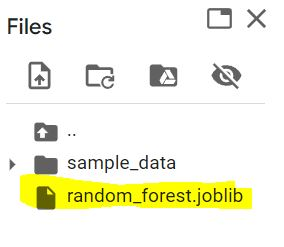

## Cargamos los datos del resto de 2020

cargamos los meses en ciclo for, rescatando el valor de f1 y dejando como variables los meses restantes, en caso de necesitar hacer otros analisis para responder nuestra pregunta.

In [18]:
#cargamos el modelo almacenado y trabajamos osbre el

rfc = joblib.load("./random_forest.joblib")

In [19]:
%%time
#creamos la variable para almacenar la data de todos los meses

taxi_test_dict = {}

for month in range(1, 13):
    month_str = f'{month:02d}'
    url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-{month_str}.parquet'
    taxi = pd.read_parquet(url)
    taxi_test = preprocess(df=taxi, target_col=target_col)
    
    # Almacena el DataFrame procesado en el diccionario
    taxi_test_dict[month_str] = taxi_test
    
    preds = rfc.predict_proba(taxi_test[features])
    preds_labels = [p[1] for p in preds.round()]
    f1 = f1_score(taxi_test[target_col], preds_labels)
    
    mes_f1_df = pd.concat([mes_f1_df, pd.DataFrame({'Mes': [month_str], 'F1': [f1]})], ignore_index=True)


CPU times: user 3min 6s, sys: 20.8 s, total: 3min 27s
Wall time: 4min 21s


In [20]:
mes_f1_df

,Mes,F1
0,01,0.729456
1,02,0.734698
2,03,0.725538
3,04,0.611764
4,05,0.616410
5,06,0.647438
6,07,0.666316
7,08,0.680725
8,09,0.705421
9,10,0.721402


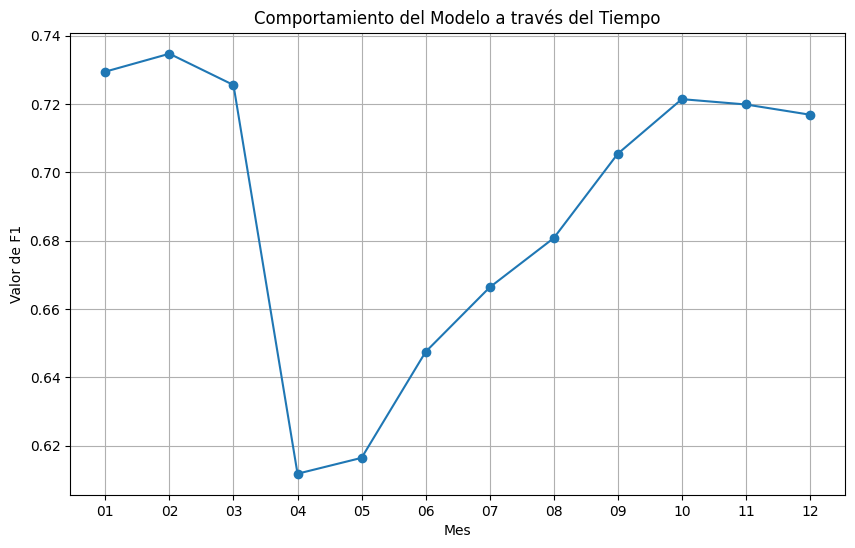

In [21]:
#visualizamos la data para tener una mejor idea
plt.figure(figsize=(10, 6))
plt.plot(mes_f1_df['Mes'], mes_f1_df['F1'], marker='o')
plt.xlabel('Mes')
plt.ylabel('Valor de F1')
plt.title('Comportamiento del Modelo a través del Tiempo')
plt.grid(True)
plt.show()

In [25]:
#taxi_test_dict

Podemos ver que hay una caida en el modelo en el mes de abril 

## Test Estadistico

ya que visualmente vimos que el f1 vaira drasticamente cercano a los inicios de la pandemia. mostrando que el modelo tiene un peor desempeno en ese moemnto y luego mejora nuevamente.

Esto nos puede decir que el modelo no se ajusta a esa realidad o que hubo menos demanda del uso del servicio.


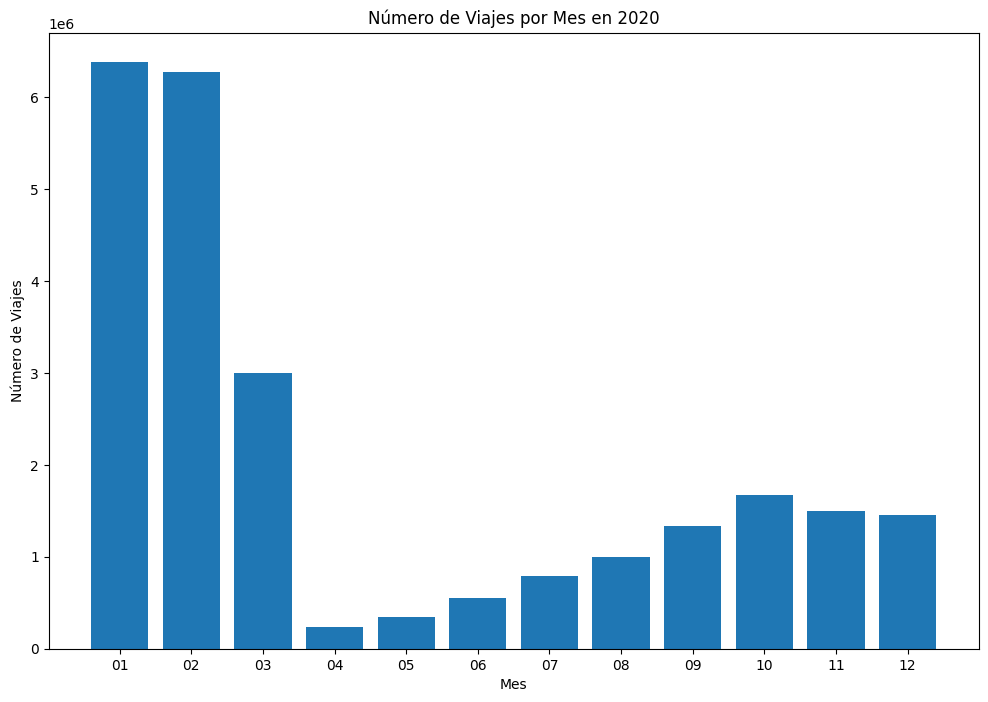

In [26]:
#para esto veamos la cantidad de viajes tomados por mes
row_counts = {month: len(taxi_test_dict[month]) for month in taxi_test_dict}

plt.figure(figsize=(12, 8))
plt.bar(row_counts.keys(), row_counts.values())
plt.xlabel('Mes')
plt.ylabel('Número de Viajes')
plt.title('Número de Viajes por Mes en 2020')
plt.show()

prematuramente podemos decir que el mayor impacto fue la cantidad de viajes tomados.

De igual manera, veamos como varian los otros datos


In [27]:
from scipy.stats import f_oneway

In [28]:
%%time
# Función para calcular el tiempo del viaje en minutos
def calculate_trip_time(df):
    if 'tpep_pickup_datetime' in df.columns and 'tpep_dropoff_datetime' in df.columns:
        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
        df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60.0
        df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    else:
        df['trip_time'] = np.nan
        df['pickup_hour'] = np.nan
    return df


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


In [29]:
def perform_anova_and_plot(parameter):
    # Verificar la presencia del parámetro en todos los DataFrames
    present_in_all_months = all(parameter in taxi_test_dict[month].columns for month in taxi_test_dict)

    if not present_in_all_months:
        print(f'El parámetro {parameter} no está presente en todos los meses. Omisión del análisis para este parámetro.')
        return

    # Extraer los valores del parámetro para cada mes, omitiendo valores nulos
    values_by_month = [taxi_test_dict[month][parameter].dropna().values for month in taxi_test_dict]

    # Verificar si los valores están vacíos o tienen poca variación
    if any(len(values) == 0 for values in values_by_month):
        print(f'El parámetro {parameter} tiene valores vacíos en algún mes. Omisión del análisis para este parámetro.')
        return

    if any(np.all(values == values[0]) for values in values_by_month):
        print(f'El parámetro {parameter} no tiene suficiente variación en algún mes. Omisión del análisis para este parámetro.')
        return

    # Realizar la prueba ANOVA
    anova_stat, anova_p_value = f_oneway(*values_by_month)
    print(f'Prueba ANOVA para {parameter}: Estadístico={anova_stat}, p-valor={anova_p_value}')

    # Si el p-valor es menor que 0.05, rechazamos la hipótesis nula de que las medias son iguales
    if anova_p_value < 0.05:
        print(f"Hay diferencias significativas en {parameter} entre los meses")
    else:
        print(f"No hay diferencias significativas en {parameter} entre los meses")

    # Visualizar las distribuciones del parámetro para cada mes
    plt.figure(figsize=(12, 8))
    plt.boxplot(values_by_month, labels=taxi_test_dict.keys())
    plt.xlabel('Mes')
    plt.ylabel(parameter.replace('_', ' ').title())
    plt.title(f'Distribución de {parameter.replace("_", " ").title()} por Mes')
    plt.show()


El parámetro payment_type no está presente en todos los meses. Omisión del análisis para este parámetro.
Prueba ANOVA para trip_distance: Estadístico=22.122785333022755, p-valor=6.8881752899540994e-46
Hay diferencias significativas en trip_distance entre los meses


/var/folders/gn/2n097ghd7ld15_l1nyrhx7wm0000gp/T/ipykernel_86680/3963789162.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values_by_month, labels=taxi_test_dict.keys())


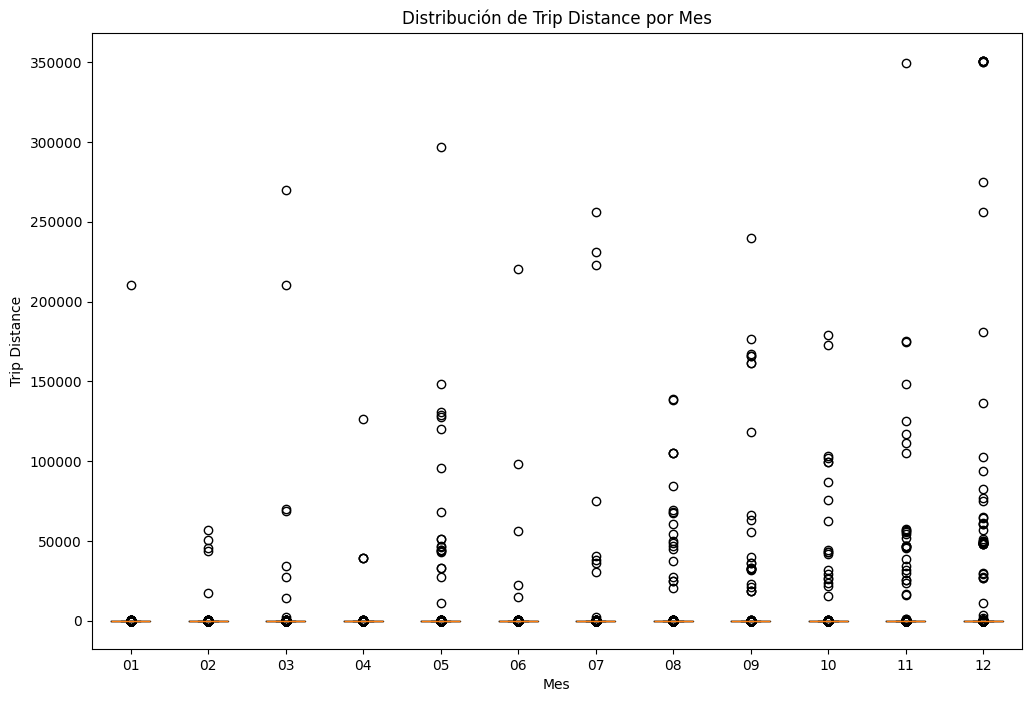

Prueba ANOVA para pickup_hour: Estadístico=2545.721327900159, p-valor=0.0
Hay diferencias significativas en pickup_hour entre los meses


/var/folders/gn/2n097ghd7ld15_l1nyrhx7wm0000gp/T/ipykernel_86680/3963789162.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values_by_month, labels=taxi_test_dict.keys())


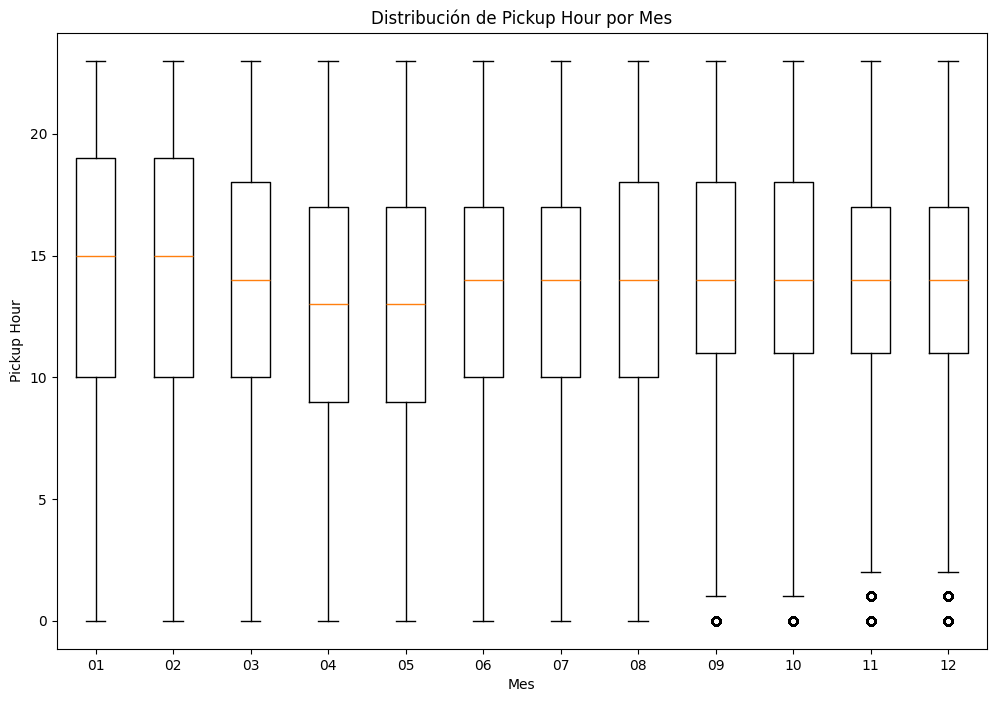

Prueba ANOVA para trip_time: Estadístico=1586.1612849258452, p-valor=0.0
Hay diferencias significativas en trip_time entre los meses


/var/folders/gn/2n097ghd7ld15_l1nyrhx7wm0000gp/T/ipykernel_86680/3963789162.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values_by_month, labels=taxi_test_dict.keys())


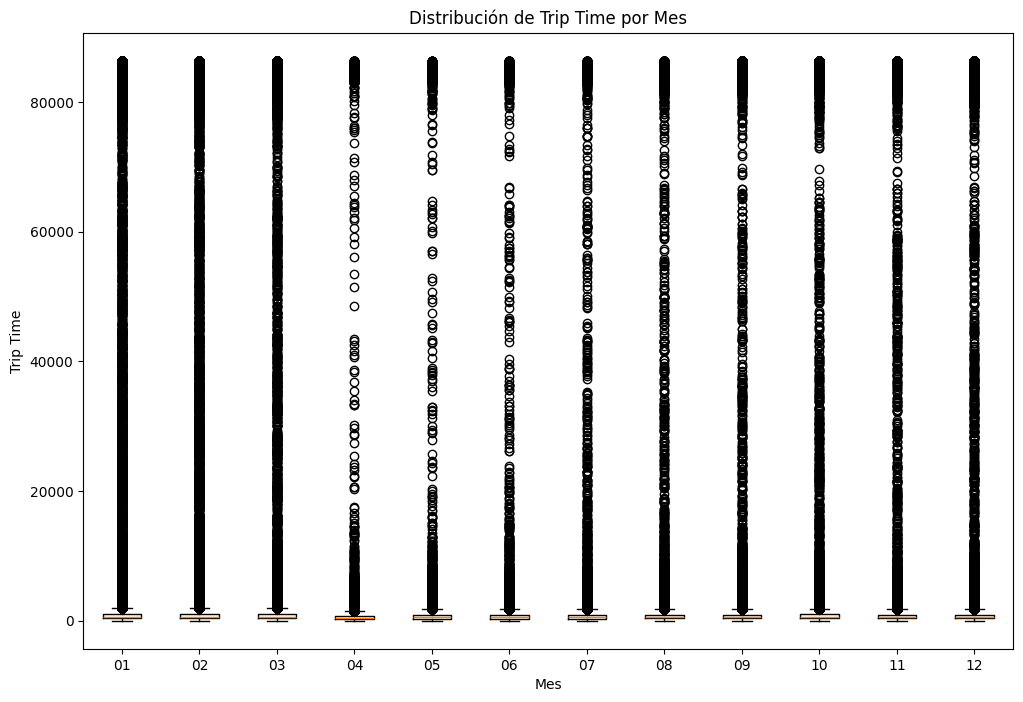

CPU times: user 6.9 s, sys: 1.35 s, total: 8.24 s
Wall time: 7.57 s


In [30]:
%%time
# Realizar el análisis ANOVA y visualización para cada parámetro
parameters = ['payment_type', 'trip_distance', 'pickup_hour', 'trip_time']
for parameter in parameters:
    perform_anova_and_plot(parameter)

de igual manera, podemos ver que la distancia de los viajes aumenta a medida que avanza el ano, no hay grandes cambios en la hora del viaje pero si un leve cambio en tiempo de viaje cuando el servicio disminuyo su uso. veamos si existe correlacion entre la distancia y la cantidad de viajes 

In [35]:
from scipy.stats import pearsonr

In [36]:
# Inicializar listas para almacenar los resultados
meses = []
distancia_media_por_mes = []
numero_de_viajes_por_mes = []

# Calcular la distancia media y el número de viajes para cada mes directamente desde taxi_test_dict
for month, df in taxi_test_dict.items():
    if 'trip_distance' in df.columns:
        # Calcular la distancia media de los viajes
        distancia_media = df['trip_distance'].dropna().mean()
        distancia_media_por_mes.append(distancia_media)
        
        # Contar el número de viajes
        numero_de_viajes = len(df)
        numero_de_viajes_por_mes.append(numero_de_viajes)
        
        # Almacenar el mes
        meses.append(month)

# Crear un DataFrame con los resultados
correlation_df = pd.DataFrame({
    'Mes': meses,
    'Distancia_Media': distancia_media_por_mes,
    'Numero_de_Viajes': numero_de_viajes_por_mes
})

# Calcular la correlación de Pearson
correlation, p_value = pearsonr(correlation_df['Distancia_Media'], correlation_df['Numero_de_Viajes'])

# Presentar los resultados numéricos
print("Análisis Numérico de Correlación:")
print(correlation_df)
print(f'\nCorrelación de Pearson: {correlation}')
print(f'p-valor: {p_value}')


Análisis Numérico de Correlación:
   Mes  Distancia_Media  Numero_de_Viajes
0   01         2.933347           6382762
1   02         2.867933           6276854
2   03         3.121393           2995357
3   04         4.053002            236611
4   05         8.295510            346612
5   06         4.113955            546843
6   07         4.316190            796346
7   08         4.390582           1001832
8   09         4.294685           1334414
9   10         3.526725           1673052
10  11         4.154675           1501059
11  12         6.095288           1453523

Correlación de Pearson: -0.5630460799944962
p-valor: 0.05663580752681095


En terminos generales, podemos ver una dismucion de efectividad en el modelo, la cual fue transitoria, pero de igual manera se aprecia una tendencia a la baja en el modelo, demostrando que si existe un deterioro intrinseco al modelo.
Por otro lado, se puede ver que la data igual tuvo un cambio, en cantidad en su mayoria y un aumento en la distancia de los viajes. los otros parametros analizados tambien mostraron cambios, pero muy leves.
Por lo que 

In [37]:
# Análisis estadístico descriptivo
estadisticas_descriptivas = mes_f1_df['F1'].describe()

# Calcular los cuartiles
Q1 = mes_f1_df['F1'].quantile(0.25)
Q3 = mes_f1_df['F1'].quantile(0.75)

# Crear un DataFrame con las estadísticas
estadisticas_df = pd.DataFrame({
    'Estadística': ['Media', 'Mediana', 'Desviación Estándar', 'Valor Mínimo', 'Valor Máximo', 'Q1', 'Q3'],
    'Valor': [estadisticas_descriptivas['mean'], 
              estadisticas_descriptivas['50%'], 
              estadisticas_descriptivas['std'], 
              estadisticas_descriptivas['min'], 
              estadisticas_descriptivas['max'], 
              Q1, 
              Q3]
})

print("Análisis Estadístico de mes_f1_df:")
print(estadisticas_df)


Análisis Estadístico de mes_f1_df:
           Estadística     Valor
0                Media  0.689655
1              Mediana  0.711135
2  Desviación Estándar  0.044360
3         Valor Mínimo  0.611764
4         Valor Máximo  0.734698
5                   Q1  0.661596
6                   Q3  0.722436


In [39]:
# Análisis estadístico descriptivo completo
estadisticas_descriptivas = mes_f1_df['F1'].describe()

# Calcular los cuartiles adicionales si es necesario
Q1 = mes_f1_df['F1'].quantile(0.25)
Q3 = mes_f1_df['F1'].quantile(0.75)

# Agregar los cuartiles al DataFrame de estadísticas
estadisticas_descriptivas.loc['25%'] = Q1
estadisticas_descriptivas.loc['75%'] = Q3

print("Análisis Estadístico de mes_f1_df:")
print(estadisticas_descriptivas)


Análisis Estadístico de mes_f1_df:
count    12.000000
mean      0.689655
std       0.044360
min       0.611764
25%       0.661596
50%       0.711135
75%       0.722436
max       0.734698
Name: F1, dtype: float64


Analizaremos tambien la tendencia 

In [40]:
from sklearn.linear_model import LinearRegression

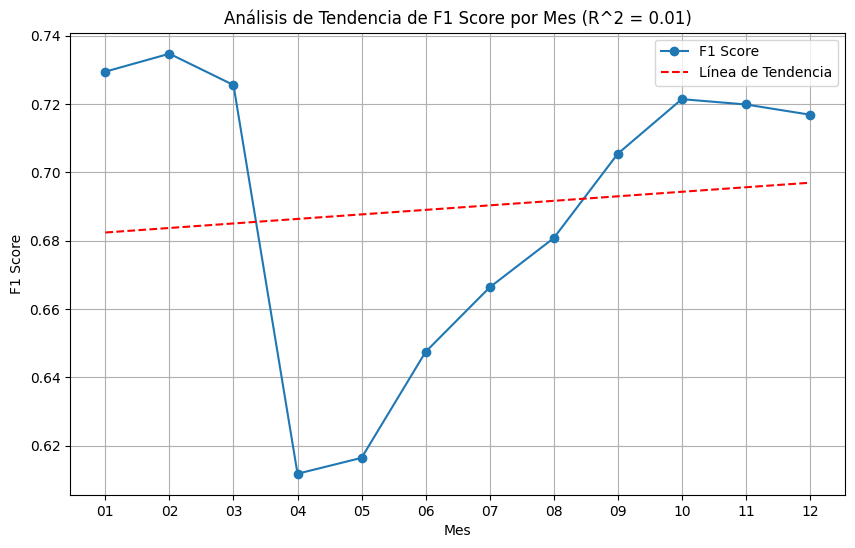

Análisis de Tendencia:
Coeficiente de Determinación (R^2): 0.01
Pendiente de la Línea de Tendencia: 0.00
Intersección de la Línea de Tendencia: 0.68


In [41]:
# Convertir la columna 'Mes' a valores numéricos para el análisis de tendencia
mes_f1_df['Mes_num'] = mes_f1_df['Mes'].astype(int)

# Preparar los datos para la regresión lineal
X = mes_f1_df['Mes_num'].values.reshape(-1, 1)
y = mes_f1_df['F1'].values

# Ajustar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X, y)

# Predicciones del modelo
y_pred = modelo.predict(X)

# Calcular el coeficiente de determinación (R^2)
r2 = modelo.score(X, y)

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(mes_f1_df['Mes'], mes_f1_df['F1'], marker='o', linestyle='-', label='F1 Score')
plt.plot(mes_f1_df['Mes'], y_pred, color='red', linestyle='--', label='Línea de Tendencia')
plt.xlabel('Mes')
plt.ylabel('F1 Score')
plt.title(f'Análisis de Tendencia de F1 Score por Mes (R^2 = {r2:.2f})')
plt.legend()
plt.grid(True)
plt.show()

# Resultados del análisis de tendencia
print("Análisis de Tendencia:")
print(f'Coeficiente de Determinación (R^2): {r2:.2f}')
print(f'Pendiente de la Línea de Tendencia: {modelo.coef_[0]:.2f}')
print(f'Intersección de la Línea de Tendencia: {modelo.intercept_:.2f}')


aunque en este caso, la tendencia se marca al alza, lo que se podria interpretar a simple vista que el modelo va a ir fuincionando de mejor manerna en el tiempo. pero con todos los parametros analizados anteriormente, podes mocncluir que lo que mejor fue la data luego de una fuerte caida, y que esta se fue mrecuperando lentamente. pero, si vemos los valores iniciales y valors finales solamente. podemos ver la caida del desempeno del modelo, esto tambien es confirmado con los analisis descriptivos visto anteriormente.

Los valores específicos del f1-score respaldan esta observación:
Valor inicial del f1-score (Enero 2020): 0.734698
Valor final del f1-score (Diciembre 2020): 0.611764